# Projet de machine learning en utilsant le processus CRISP-DM
Ajouter les sources :
- https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
- Smartphone and Smartwatch-Based Biometrics Using Activities of Daily Living. IEEE Access, 7:133190-133202, Sept. 2019.

## Compréhension des affaires
*Il s'agira d'expliquer les objectifs du projet et de détailler le plan du projet*

## Compréhension des données
### Mise en place

In [100]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Récupération des données

In [101]:
import zipfile
import urllib

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/"
WISDM_PATH = os.path.join("datasets", "wisdm")
WISDM_URL = DOWNLOAD_ROOT + "wisdm-dataset.zip"

def fetch_wisdm_data(wisdm_url=WISDM_URL, wisdm_path=WISDM_PATH):
    if not os.path.isdir(wisdm_path):
        os.makedirs(wisdm_path)
    zip_path = os.path.join(wisdm_path, "wisdm-dataset.zip")
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(wisdm_url, zip_path)
    uncompressed_path = os.path.join(wisdm_path, "wisdm-dataset")
    if not os.path.isdir(uncompressed_path):
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(wisdm_path)

In [102]:
fetch_wisdm_data()

### Description des données

Les données sont décrites dans le fichier WISDM-dataset-description.pdf du jeu de données précédemment téléchargé.
Ce jeu de données est composé de données provenant de 51 personnes à qui on a demandé de réaliser 18 tâches de 3 minutes. Chacun des sujets a une smartwatch attachée au poignet de leurs mains dominantes et un smartphone dans leurs poches. Les données collectées proviennent des girocscopes et des accéléromètres de la montre et du téléphone.

Un pré-traitement des données a déja été fait dans le jeu de données. Il en résulte un des données etiquetées sur les exemples au lieu de données étiquetées sur une série temporelle. Le traitement pour faire cela consiste à utiliser une fonction porte de 10s sur chaque série temporelle de données.

#### Les données brutes

In [103]:
def load_raw_wisdm_data(subjectId, wisdm_path=WISDM_PATH):
    subjectIdStr = str(subjectId)
    rawPath = os.path.join(WISDM_PATH,'wisdm-dataset','raw','phone','accel','data_'+subjectIdStr+'_accel_phone.txt')
    f = open(rawPath, 'r')
    lines = f.readlines()
    data=[[],[],[]]
    timestamp=[]
    for l in lines:
        data[0].append(float(l.split(',')[3]))
        data[1].append(float(l.split(',')[4]))
        data2=l.split(',')[5].split(';')[0]
        data[2].append(float(data2))
        timestamp.append(int(l.split(',')[2]))
    return data,timestamp

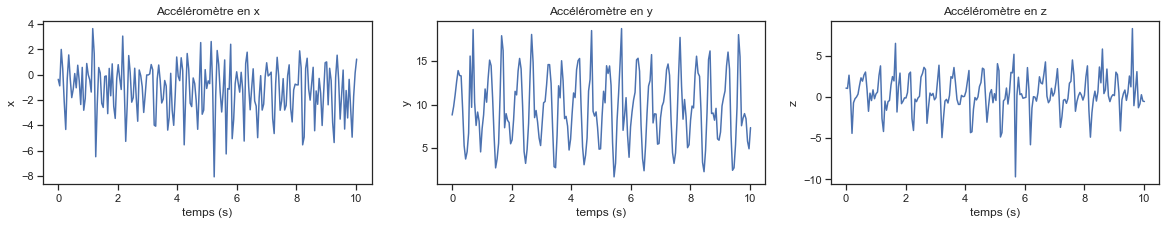

In [104]:
rawData,timestamp = load_raw_wisdm_data(1600)
timestamp = [(x-timestamp[0])*10**-9 for x in timestamp]

plt.figure(figsize=(20,3))

plt.subplot(131)
plt.title('Accéléromètre en x')
plt.xlabel('temps (s)')
plt.ylabel('x')
plt.plot(timestamp[0:200],rawData[0][0:200])

plt.subplot(132)
plt.title('Accéléromètre en y')
plt.xlabel('temps (s)')
plt.ylabel('y')
plt.plot(timestamp[0:200],rawData[1][0:200])

plt.subplot(133)
plt.title('Accéléromètre en z')
plt.xlabel('temps (s)')
plt.ylabel('z')
plt.plot(timestamp[0:200],rawData[2][0:200])
plt.show()

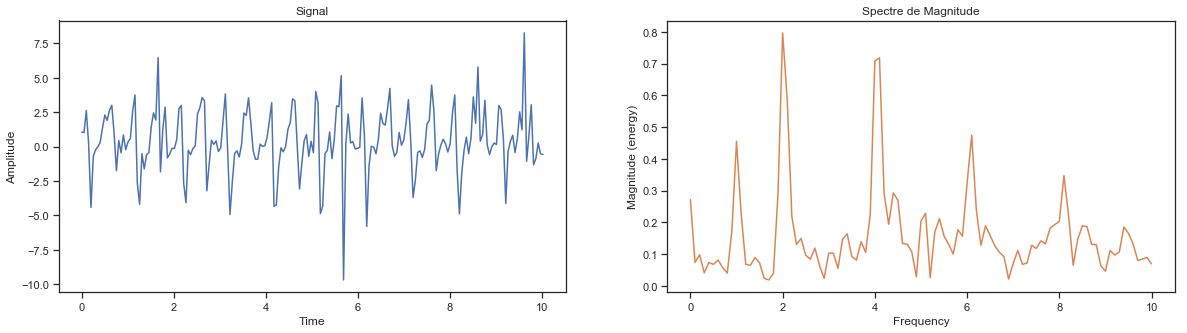

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

t=timestamp[0:200]
s=rawData[2][0:200]
# plot time signal:
axes[0].set_title("Signal")
axes[0].plot(t, s, color='C0')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")

# plot different spectrum types:
axes[1].set_title("Spectre de Magnitude")
axes[1].magnitude_spectrum(s,Fs=20, color='C1')

plt.show()

#### Les donées pré-traitées

In [106]:
# library for reading arff file
# You can install it via 'pip install liac-arff'
# https://pypi.org/project/liac-arff/ for more informations
import arff
import pandas as pd

def load_wisdm_data(subjectId, wisdm_path=WISDM_PATH):
    subjectIdStr = str(subjectId)
    arffPath = os.path.join(WISDM_PATH,'wisdm-dataset','arff_files','phone','accel','data_'+subjectIdStr+'_accel_phone.arff')
    data = arff.load(open(arffPath, 'r'))
    attributesName = [data['attributes'][i][0] for i in range (len(data['attributes']))]
    dataFrame = pd.DataFrame(data = data['data'], columns=attributesName)
    return dataFrame

In [107]:
subject1600 = load_wisdm_data(1600)
subject1600.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.235,0.470,0.275,0.020,0.000,0.0,0.0,0.0,0.0,...,0.486106,0.479859,-0.550668,0.049864,0.121354,-0.251024,0.164468,-0.110722,10.05180,1600
1,A,0.275,0.440,0.270,0.015,0.000,0.0,0.0,0.0,0.0,...,0.479571,0.473409,-0.633171,0.072129,0.161492,-0.386416,0.215680,-0.034375,10.11710,1600
2,A,0.320,0.430,0.245,0.000,0.005,0.0,0.0,0.0,0.0,...,0.483005,0.476798,-0.659493,0.087043,0.162157,-0.325151,0.272380,-0.077274,9.98384,1600
3,A,0.315,0.495,0.185,0.005,0.000,0.0,0.0,0.0,0.0,...,0.480711,0.474534,-0.712081,0.003810,0.210015,-0.364285,0.203131,0.015328,10.10600,1600
4,A,0.215,0.455,0.325,0.005,0.000,0.0,0.0,0.0,0.0,...,0.468836,0.462811,-0.534933,0.047553,0.275833,-0.216423,0.238500,-0.009870,10.05210,1600


In [108]:
subject1600.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.0,321.0,...,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,0.128816,0.264517,0.319969,0.235031,0.051277,0.000312,0.000047,0.000031,0.0,0.0,...,0.339085,0.335138,0.330831,0.221916,0.558735,0.595346,-0.100686,0.105777,-0.421535,9.697830
std,0.214657,0.335906,0.415449,0.402267,0.206116,0.001499,0.000482,0.000394,0.0,0.0,...,0.143267,0.141599,0.139780,0.862872,0.579945,0.550815,0.365069,0.421341,0.391955,0.460055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-0.060974,-0.060264,-0.059490,-0.999917,-0.997769,-0.952187,-0.999753,-0.986312,-0.999803,9.171570
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.327565,0.323752,0.319591,-0.724125,0.098196,0.151871,-0.322235,-0.179483,-0.738426,9.327910
50%,0.000000,0.000000,0.120000,0.005000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.367562,0.363283,0.358614,0.986246,0.965633,0.994368,-0.076160,0.100942,-0.557509,9.637580
75%,0.240000,0.520000,0.905000,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.409566,0.404798,0.399596,0.999207,0.999106,0.999577,0.127908,0.442266,-0.053193,9.985840
max,1.000000,1.000000,1.000000,1.000000,0.995000,0.010000,0.005000,0.005000,0.0,0.0,...,0.664408,0.656673,0.648235,0.999982,0.999951,0.999939,0.975860,0.999756,0.565919,11.428800


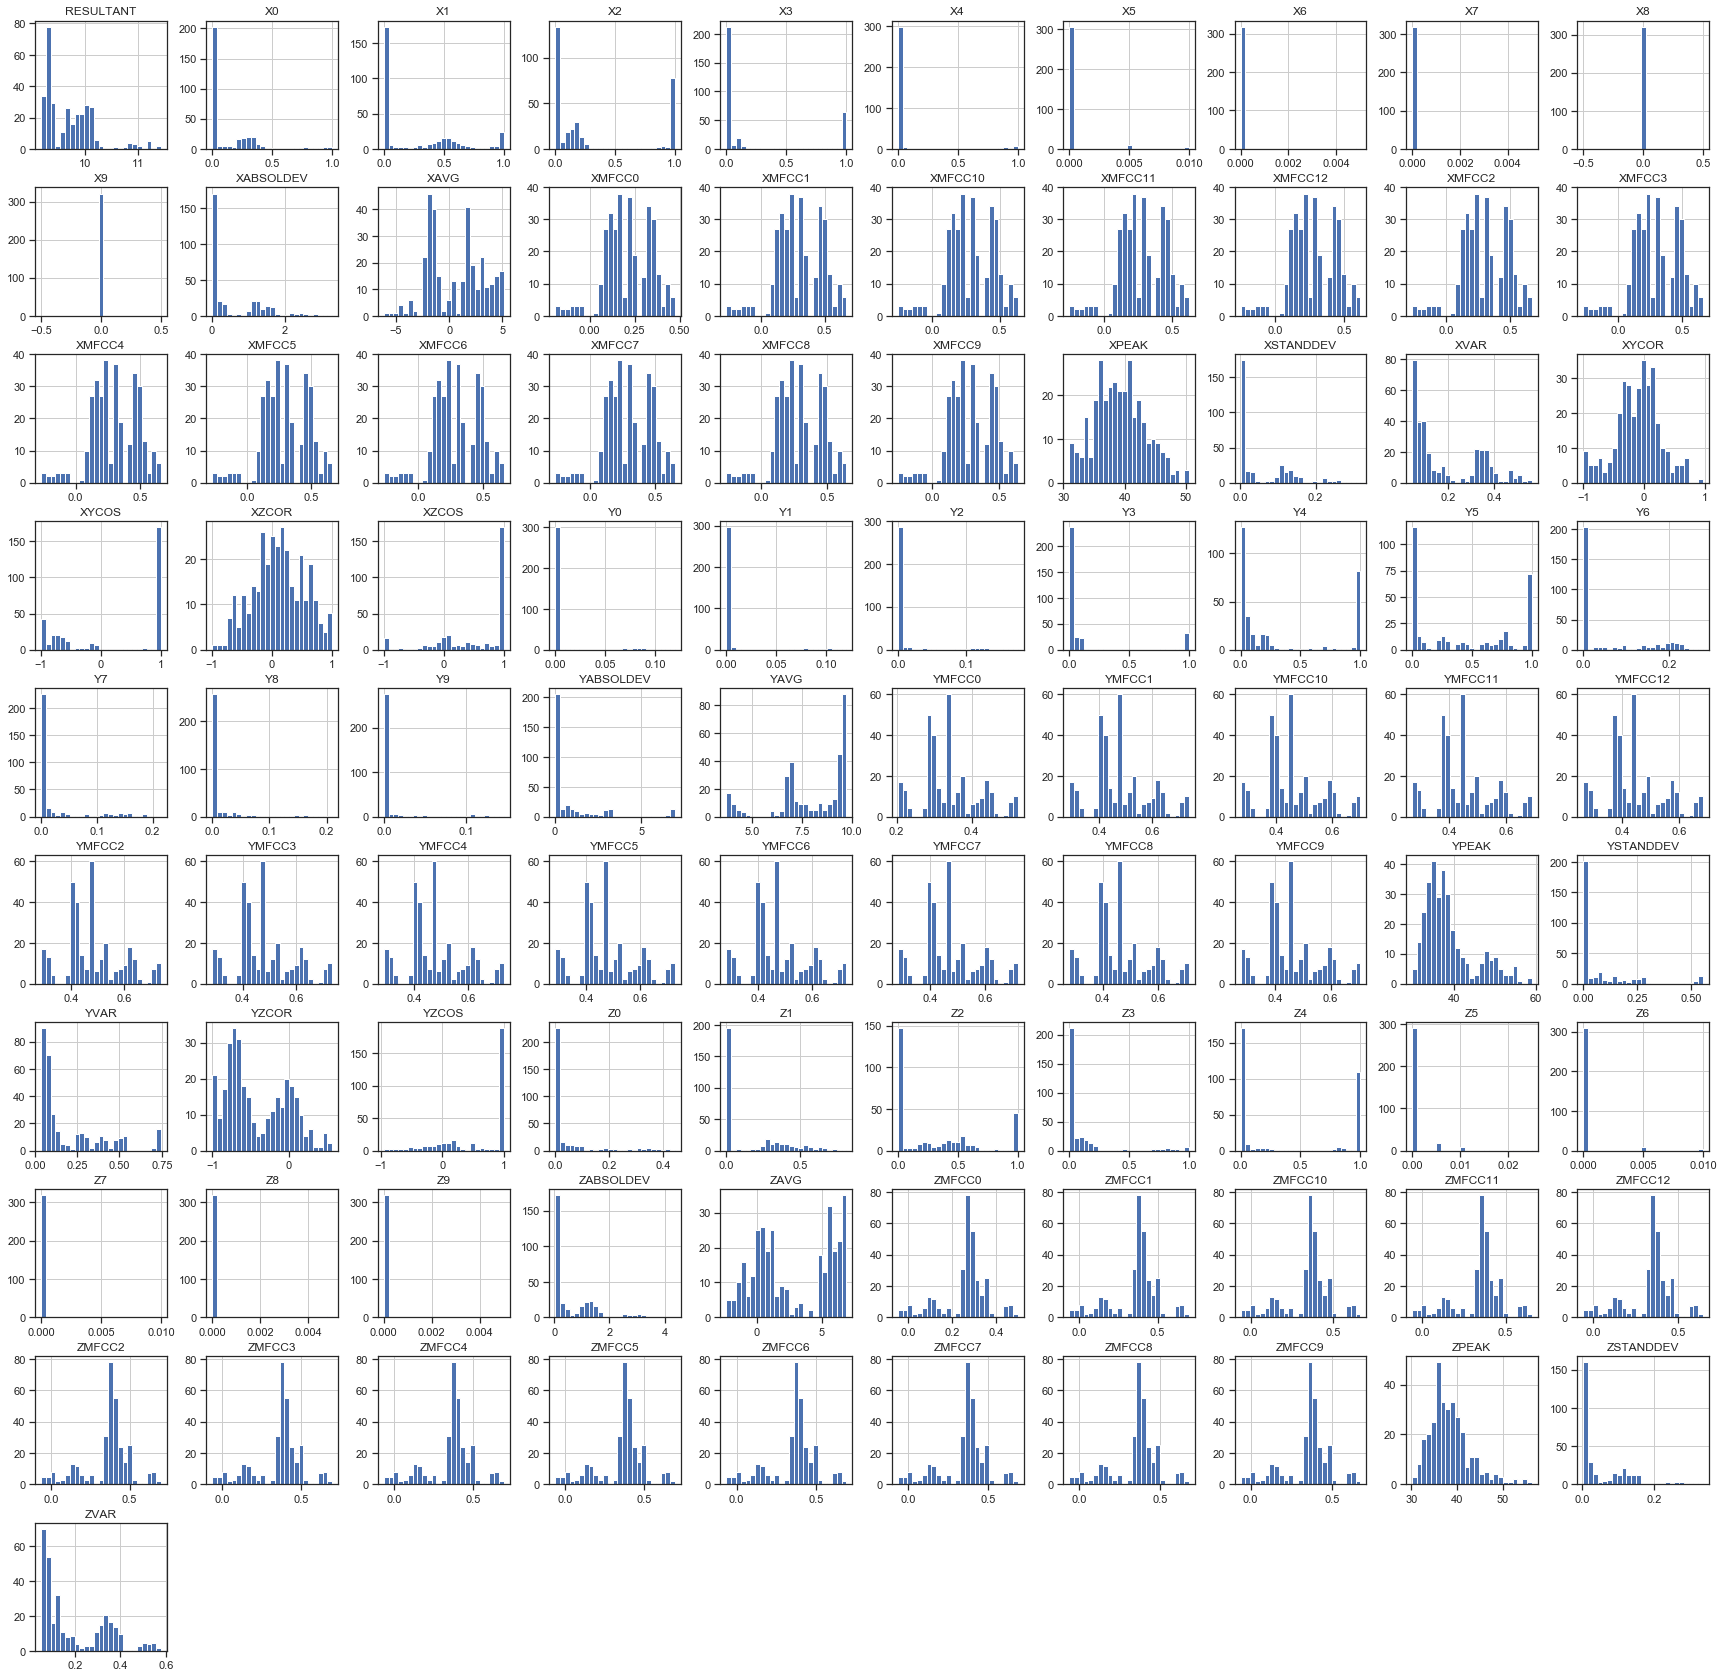

In [125]:
subject1600.hist(bins = 25, figsize=(30,30))
#save_fig("attribute_histogram_plots")
plt.show()

On remarque dans l'histogramme que certains attributs comme X0 et X3 n'ont que très peu de dispersion. D'autres n'ont aucune dispersion comme X7 et X8 qui sont nuls tout le temps. On va essayer de voir si ces attributs sont utiles ou si on peut les enlever pour la suite.  
Les histogrammes XMFCC{0-12} semble similaires, on peut regarder le coefficient de corrélation entre ces derniers pour connaitre le niveau de similitude de ces attributs.

In [110]:
corr_matrix = subject1600.corr()
corr_matrix["XMFCC1"].sort_values(ascending=False)

XMFCC1       1.000000
XMFCC2       1.000000
XMFCC8       1.000000
XMFCC4       1.000000
XMFCC3       1.000000
XMFCC11      1.000000
XMFCC7       1.000000
XMFCC6       1.000000
XMFCC5       1.000000
XMFCC9       1.000000
XMFCC10      1.000000
XMFCC12      1.000000
XMFCC0       1.000000
XVAR         0.815663
XSTANDDEV    0.801188
YVAR         0.794162
XABSOLDEV    0.790984
ZVAR         0.789268
ZSTANDDEV    0.767285
ZABSOLDEV    0.750062
Y6           0.719635
YSTANDDEV    0.708649
ZMFCC12      0.683061
ZMFCC0       0.683061
ZMFCC2       0.683061
ZMFCC5       0.683061
ZMFCC9       0.683061
ZMFCC10      0.683061
ZMFCC4       0.683061
ZMFCC8       0.683061
               ...   
Z5           0.409272
X5           0.353267
X1           0.325542
Z6           0.321553
Z8           0.189097
Z7           0.172657
X6           0.164957
Z9           0.156396
X7           0.144988
Y3           0.128599
XYCOR        0.120323
YAVG         0.118720
ZPEAK        0.102781
X4           0.086494
XZCOR     

Les attributs XMFCC{0-12} sont effectivement corrélés avec un coefficient égal à 1. Il ne semble pas important de garder tout ces attributs pour le sujet 1600.  
On va alors regarder si ces attributs sont inutiles pour tous les sujets ou si'ils le sont seulement pour le sujet 1600 afin de savoir si l'on peu les retirer.

In [ ]:
import random
import pandas as pd

SUBJECT_NUMBER = 51
FIRST_SUBJECT_ID=1600
l = [i+FIRST_SUBJECT_ID for i in range(SUBJECT_NUMBER)]
SUBJECTSID= l.remove(1614)

def load_multiple_wisdm_data(subjectToExtractNumber):
    #for reproductibility
    random.seed(1)
    subjectToExtract = random.sample(l,subjectToExtractNumber)
    
    subject = load_wisdm_data(1600) 
    subjectsDf = pd.DataFrame(columns=subject.columns)
    for i in range(subjectToExtractNumber):
        subjectDf = load_wisdm_data(subjectToExtract[i])
        subjectsDf = subjectsDf.append(subjectDf)
    return subjectsDf

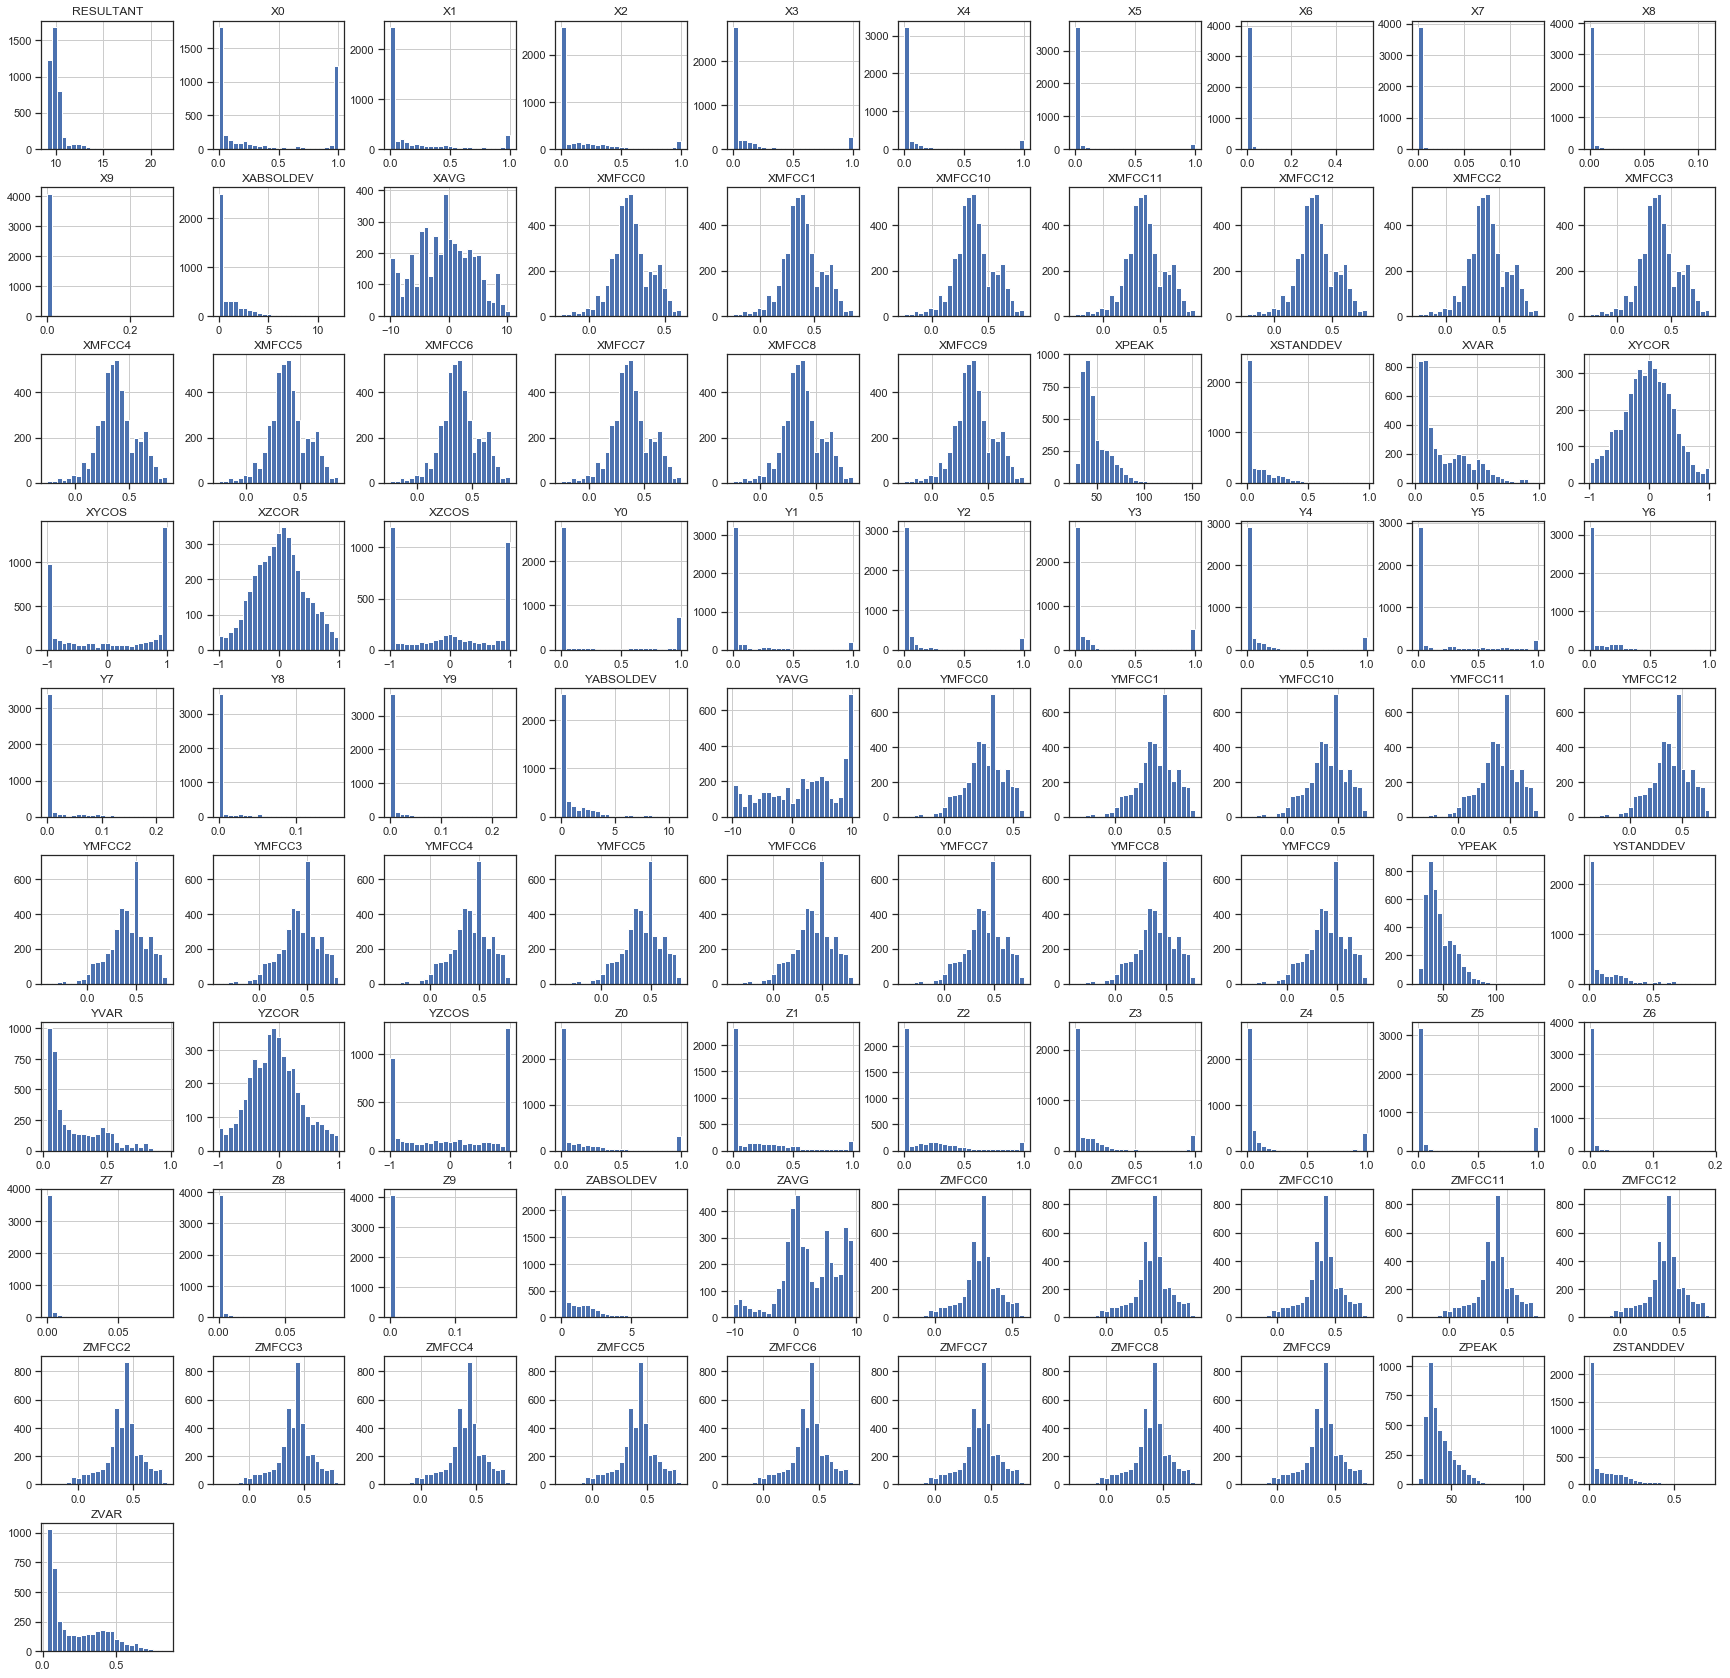

In [130]:
subjects = load_multiple_wisdm_data(10)
subjects.hist(bins = 25, figsize=(30,30))
#save_fig("attribute_histogram_plots")
plt.show()